<a href="https://colab.research.google.com/github/soffiyahabass1/ArewaDS-Deep-Learning/blob/main/Assignment_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Name : Taiwo Soffiyah Abass
Email: Soffiyahabass1@gmail.com
Tittle: Week 3

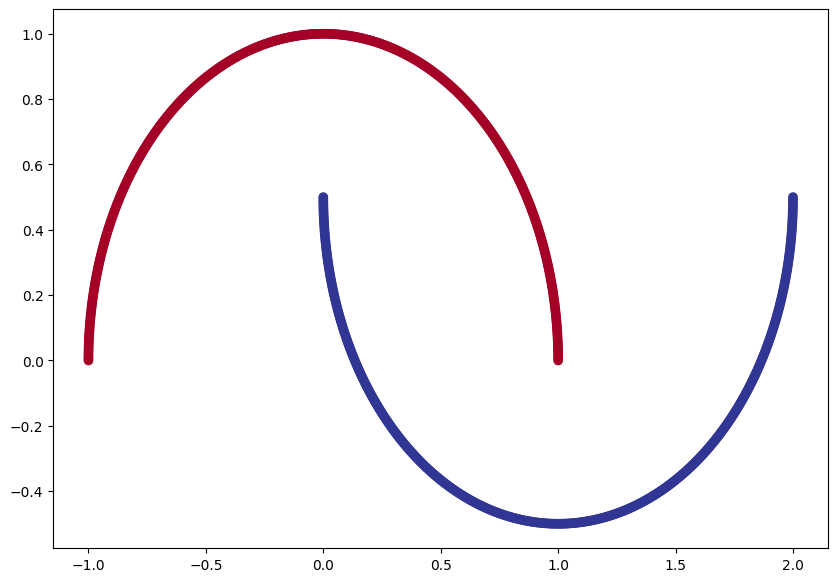

In [3]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from torch import nn
from sklearn.model_selection import train_test_split

X_moon,y_moon= make_moons(n_samples=1000, random_state=42)

plt.figure(figsize=(10,7))
plt.scatter(X_moon[:,0], X_moon[:,1], c=y_moon, cmap=plt.cm.RdYlBu);


In [4]:
X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon= torch.from_numpy(y_moon).type(torch.float)


In [5]:

X_moon_train,X_moon_test, y_moon_train, y_moon_test = train_test_split(X_moon,
                                                                       y_moon,
                                                                       test_size =0.2,
                                                                       random_state=42)

In [6]:
print(f"first 5 X features:\n {X_moon[:5]}")
print(f"first 5 y labels \n{y_moon[:5]}")
print (f"shape of X:\n {X_moon.shape}")
print( f"shape of y:\n{y_moon.shape}")

first 5 X features:
 tensor([[ 0.0087,  0.3682],
        [ 0.9214, -0.4969],
        [ 0.9402, -0.4982],
        [ 0.4659, -0.3454],
        [-0.8504,  0.5261]])
first 5 y labels 
tensor([1., 1., 1., 1., 0.])
shape of X:
 torch.Size([1000, 2])
shape of y:
torch.Size([1000])


In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [8]:
class Module (nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))\

model_1 = Module().to(device)
model_1

Module(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [9]:
class MoonModelV0(nn.Module):
    def __init__(self, in_features, out_features, hidden_units):
        super().__init__()

        self.layer1 = nn.Linear(in_features=in_features,
                                 out_features=hidden_units)
        self.layer2 = nn.Linear(in_features=hidden_units,
                                 out_features=hidden_units)
        self.layer3 = nn.Linear(in_features=hidden_units,
                                out_features=out_features)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer3(self.relu(self.layer2(self.relu(self.layer1(x)))))
model_1 = MoonModelV0(in_features=2,
                      out_features=1,
                      hidden_units=10).to(device)
model_1


MoonModelV0(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [10]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.01)

In [11]:
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true,y_pred).sum().item()
  acc = (correct/ len(y_pred))*100
  return acc

In [12]:
y_preds = torch.round(torch.sigmoid(model_1(X_moon_test.to(device))[:5]))  # Get binary predictions
y_preds = y_preds.squeeze(dim=1)  # Remove extra dimension

y_test_sample = y_moon_test[:5].to(device)  # Get first 5 ground truth labels
print(torch.eq(y_preds, y_test_sample))  # Check for equality
y_preds.squeeze()

tensor([ True, False,  True, False,  True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [13]:
# Ensure correct dataset assignment
X_moon_train, y_moon_train = X_moon_train.to(device), y_moon_train.to(device)
X_moon_test, y_moon_test = X_moon_test.to(device), y_moon_test.to(device)
epochs = 1000

# Print shapes to debug
print(f"X_moon_train shape: {X_moon_train.shape}, y_moon_train shape: {y_moon_train.shape}")
print(f"X_moon_test shape: {X_moon_test.shape}, y_moon_test shape: {y_moon_test.shape}")

for epoch in range(epochs):
    model_1.train()
    y_logits = model_1(X_moon_train)
    y_preds = torch.round(torch.sigmoid(y_logits))  # Sigmoid for binary classification

    loss = loss_fn(y_logits, y_moon_train.unsqueeze(1))
    acc = accuracy_fn(y_true=y_moon_train, y_pred=y_preds.squeeze(1))

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_moon_test)  # Ensure correct test data
        test_pred = torch.round(torch.sigmoid(test_logits))  # Apply sigmoid

        test_loss = loss_fn(test_logits, y_moon_test.view_as(test_logits))  # Ensure matching shape
        test_ac = accuracy_fn(y_true=y_moon_test, y_pred=test_pred.squeeze(1))

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_ac:.2f}%")


X_moon_train shape: torch.Size([800, 2]), y_moon_train shape: torch.Size([800])
X_moon_test shape: torch.Size([200, 2]), y_moon_test shape: torch.Size([200])
Epoch: 0 | Loss: 0.70830, Acc: 50.00% | Test Loss: 0.70681, Test Acc: 50.00%
Epoch: 10 | Loss: 0.70554, Acc: 50.00% | Test Loss: 0.70424, Test Acc: 50.00%
Epoch: 20 | Loss: 0.70287, Acc: 50.00% | Test Loss: 0.70176, Test Acc: 50.00%
Epoch: 30 | Loss: 0.70030, Acc: 50.00% | Test Loss: 0.69935, Test Acc: 50.00%
Epoch: 40 | Loss: 0.69779, Acc: 50.00% | Test Loss: 0.69703, Test Acc: 50.00%
Epoch: 50 | Loss: 0.69535, Acc: 50.00% | Test Loss: 0.69476, Test Acc: 50.00%
Epoch: 60 | Loss: 0.69298, Acc: 50.00% | Test Loss: 0.69255, Test Acc: 50.00%
Epoch: 70 | Loss: 0.69065, Acc: 50.00% | Test Loss: 0.69040, Test Acc: 50.00%
Epoch: 80 | Loss: 0.68836, Acc: 50.00% | Test Loss: 0.68829, Test Acc: 50.00%
Epoch: 90 | Loss: 0.68612, Acc: 50.00% | Test Loss: 0.68621, Test Acc: 50.00%
Epoch: 100 | Loss: 0.68389, Acc: 50.00% | Test Loss: 0.68415, T

In [14]:
model_1.eval()
with torch.inference_mode():
  y_preds = torch.round(torch.sigmoid(model_1(X_moon_test))).squeeze()
y_preds[:10], y_moon[:10]

(tensor([1., 0., 1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [15]:
import requests
from pathlib import Path

#download helper functions from learn pytorch repo

if Path ("helper_functions.py").is_file():
  print("helper_functions.py already exists")
else:
  print("downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


downloading helper_functions.py


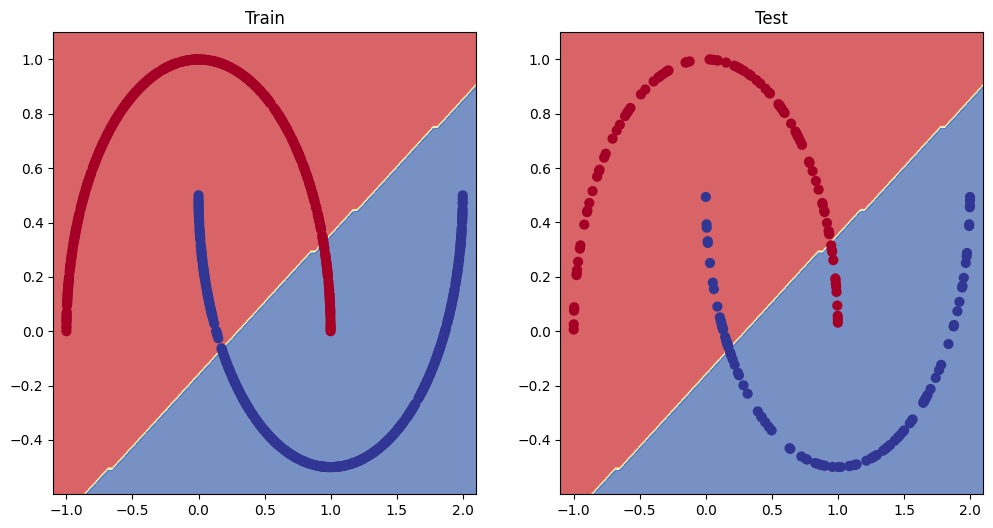

In [16]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_1, X_moon_train,y_moon_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_1, X_moon_test, y_moon_test)

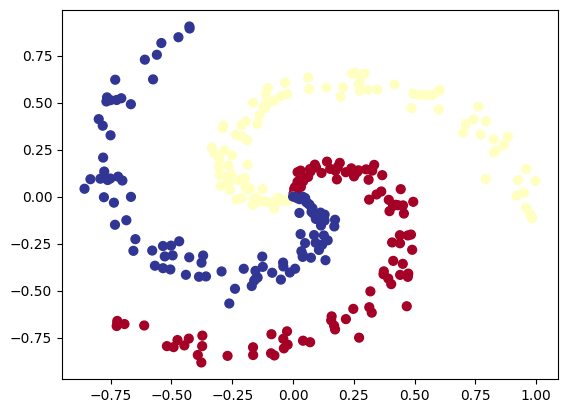

In [17]:
import numpy as np
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
plt.show()

In [18]:
X = torch.from_numpy(X).type(torch.float) # features as float32
y = torch.from_numpy(y).type(torch.LongTensor) # labels need to be of type long

# Create train and test splits
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)
len(X_train), len(X_test), len(y_train), len(y_test)

(240, 60, 240, 60)

In [19]:
from torch import nn
input_features=2
output_features = 3
hidden_units=10

class Model(nn.Module):
  def __init__ (self):


     super().__init__()
     self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_features),

        )
  def forward(self, x):
      return self.linear_layer_stack(x)
model_2 = Model().to(device)
model_2

Model(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
    (4): Linear(in_features=10, out_features=3, bias=True)
  )
)

In [20]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(),
                            lr= 0.1)

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cuda'

In [30]:
#training loop

torch.manual_seed(42)

epochs = 1000

X_train, y_train =X_train.to(device), y_train.to(device)
X_test, y_test =X_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_2.train()

  #forward pass


  y_logits=model_2(X_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)

  loss = loss_fn(y_logits,y_train)
  acc = accuracy_fn(y_true=y_train,
                    y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()
  optimizer.step()

  #testing

  model_2.eval()
  with torch.inference_mode():

   test_logits = model_2(X_test)
   test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)

   test_loss = loss_fn(test_logits, y_test)
   test_ac = accuracy_fn(y_true=y_test,
                        y_pred=test_pred

                        )
if epoch % 100==0:
   print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_ac:.2f}%")



In [31]:
model_2.eval()
with torch.inference_mode():
  y_logits=model_2(X_test)
y_logits[:10]

tensor([[-10.9294,   4.7171,   6.8572],
        [-11.8758,   5.0480,   7.6271],
        [  1.3780,   0.4134,  -3.1543],
        [  1.3780,   0.4134,  -3.1543],
        [-30.5682, -43.9732,  36.2531],
        [-38.5785, -30.1012,  40.2333],
        [  3.2645,  39.2912,   8.4665],
        [ -0.4316,   1.0462,  -1.6823],
        [  1.3780,   0.4134,  -3.1543],
        [  3.9943,  54.3316,  12.9622]], device='cuda:0')

In [32]:
y_pred_probs = torch.softmax(y_logits, dim=1)
y_preds = y_pred_probs.argmax(dim=1)

print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}%")

Predictions: tensor([2, 2, 0, 0, 2, 2, 1, 1, 0, 1], device='cuda:0')
Labels: tensor([2, 2, 1, 0, 2, 2, 1, 1, 0, 1], device='cuda:0')
Test accuracy: 93.33333333333333%


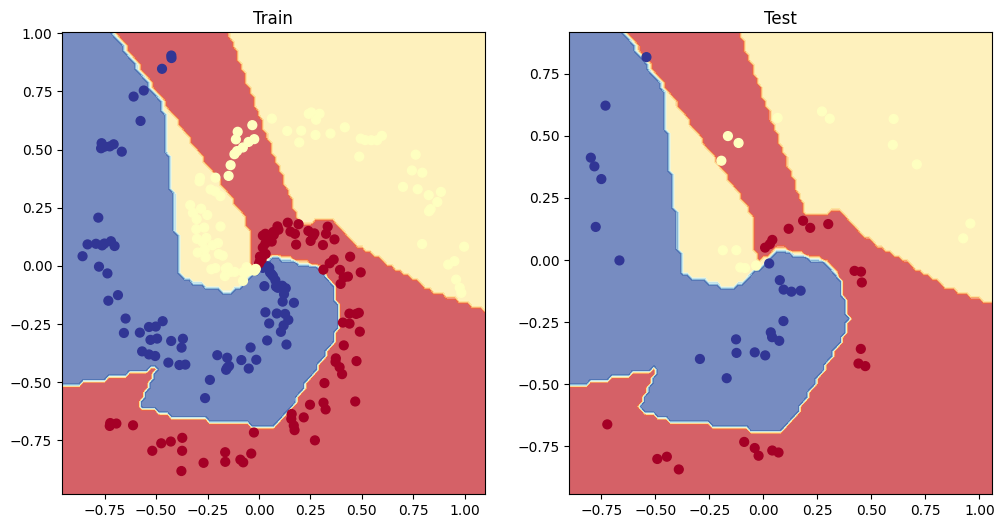

In [33]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_2,X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test)

In [34]:
A = torch.arange(-10,10,1)
A

tensor([-10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,   1,   2,   3,
          4,   5,   6,   7,   8,   9])

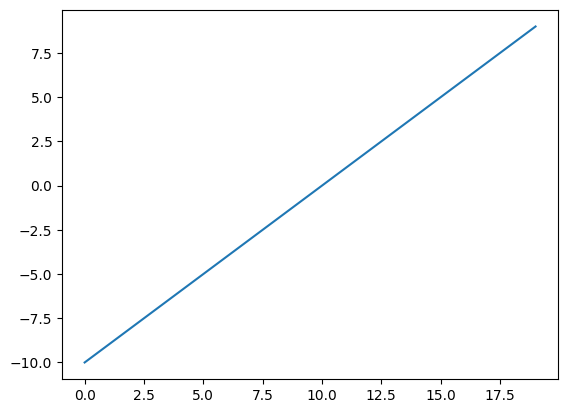

In [35]:
plt.plot(A);

In [36]:
def tanh(x):
  return (torch.exp(x)- torch.exp(-x)) / (torch.exp(x) + torch.exp(-x))

tanh(A)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
        -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
         1.0000,  1.0000,  1.0000,  1.0000])

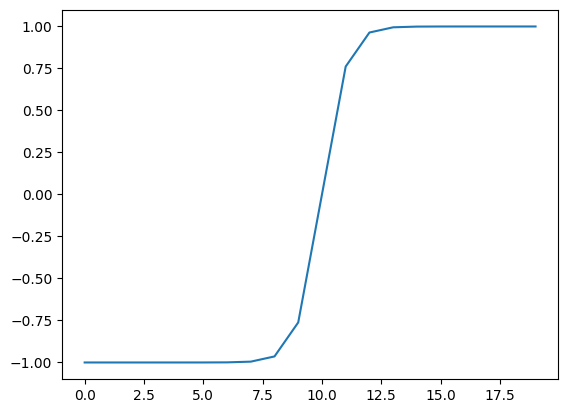

In [37]:
plt.plot(tanh(A))